In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [2]:
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage5.h5', 'test_df',mode='r')

In [3]:
df_final_train.head(3)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followee,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,9.068719e-04
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,980,902,1.787503e-35,2.467873e-36


In [4]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [5]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)


In [6]:
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [8]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2], 
        'n_estimators' :[100,200,500,1000,2000],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
          }
xgb1 = XGBClassifier()          
random_xgb1=RandomizedSearchCV(xgb1,param_distributions = params,verbose=10,n_jobs=-1)
random_xgb1.fit(df_final_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[06:33:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_param

In [9]:
print(random_xgb1.best_params_)

{'subsample': 0.6, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.8}


In [17]:
from sklearn.calibration import CalibratedClassifierCV
gdb = XGBClassifier(sub_sample=0.6,learning_rate = 0.1,colsample_bytree=0.8,max_depth=4,n_estimators=2000,min_child_weight=1,gamma=2)
gdb.fit(df_final_train,y_train)
clf = CalibratedClassifierCV(gdb,method="sigmoid")
clf.fit(df_final_train,y_train)

[08:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:01:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    gamma=2, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_constraints

Train confusion matrix


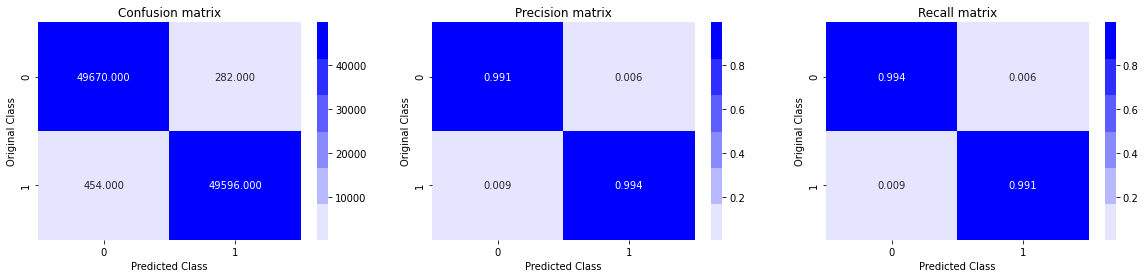

Test confusion matrix


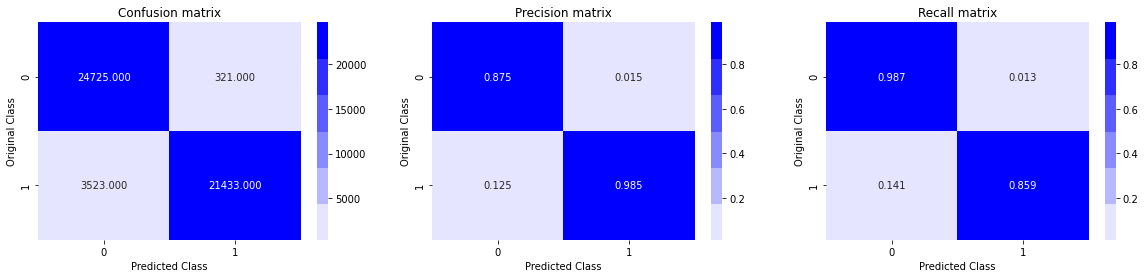

In [18]:
print("Train confusion matrix")
plot_confusion_matrix(y_train,clf.predict(df_final_train))
print("Test confusion matrix")
plot_confusion_matrix(y_test,clf.predict(df_final_test))

In [19]:
from sklearn.metrics import f1_score
print("f1 score for train data",f1_score(y_train,clf.predict(df_final_train)))
print("f1 score for test data",f1_score(y_test,clf.predict(df_final_test)))

f1 score for train data 0.9926346969818269
f1 score for test data 0.9177049882252195


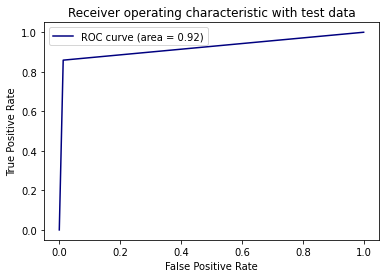

In [20]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,clf.predict(df_final_test))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

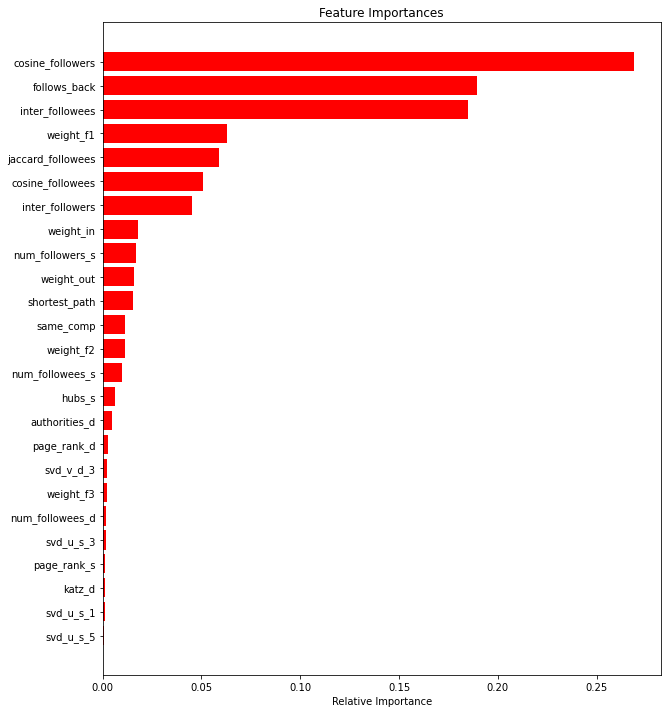

In [21]:
features = df_final_train.columns
importances = gdb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [15]:
from prettytable import PrettyTable
t = PrettyTable()
t.field_names=["model","train_f1_Score","test_f1_score"]
t.add_row(["XGBoost","0.9920553921274338","0.9124241511382708"])
print(t)

+---------+--------------------+--------------------+
|  model  |   train_f1_Score   |   test_f1_score    |
+---------+--------------------+--------------------+
| XGBoost | 0.9920553921274338 | 0.9124241511382708 |
+---------+--------------------+--------------------+
